In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import (accuracy_score, confusion_matrix,
                             roc_curve, auc,
                             precision_recall_curve)
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
%matplotlib inline

df = pd.read_parquet('../data/processed/model_ready_dataset.parquet')

# Cargar modelo guardado
with open('../models/saved_models/best_model_lr.pkl', 'rb') as f:
    lr_model = pickle.load(f)

with open('../models/saved_models/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

with open('../models/saved_models/features.pkl', 'rb') as f:
    all_features = pickle.load(f)

In [4]:
# Preparamos datos y generamos predicciones

print("Preparando datos")
print("="*60)

from sklearn.model_selection import train_test_split

exclude_cols = ['Match Name', 'teamA_name', 'teamB_name', 'Team A', 'Team B', 'Match Result', 'teamA_won', 'year']

X = df[all_features].fillna(df[all_features].median())
y = df['teamA_won']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Escalar
X_test_scaled = scaler.transform(X_test)

# Generar predicciones
y_pred = lr_model.predict(X_test_scaled)
y_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

# Crear DataFrame con resultados
df_results = df.loc[X_test.index].copy()
df_results['predicted'] = y_pred
df_results['probability_teamA'] = y_pred_proba
df_results['correct'] = (y_pred == y_test.values).astype(int)

print(f"Predicciones generadas: {len(df_results):,} partidos")
print(f"\nResumen:")
print(f"- Correctas: {df_results['correct'].sum():,} ({df_results['correct'].mean()*100:.1f}%)")
print(f"- Incorrectas: {(1-df_results['correct']).sum():,} ({(1-df_results['correct']).mean()*100:.1f}%)")

Preparando datos
Predicciones generadas: 1,724 partidos

Resumen:
- Correctas: 1,624 (94.2%)
- Incorrectas: 100 (5.8%)


Curvas de evaluación


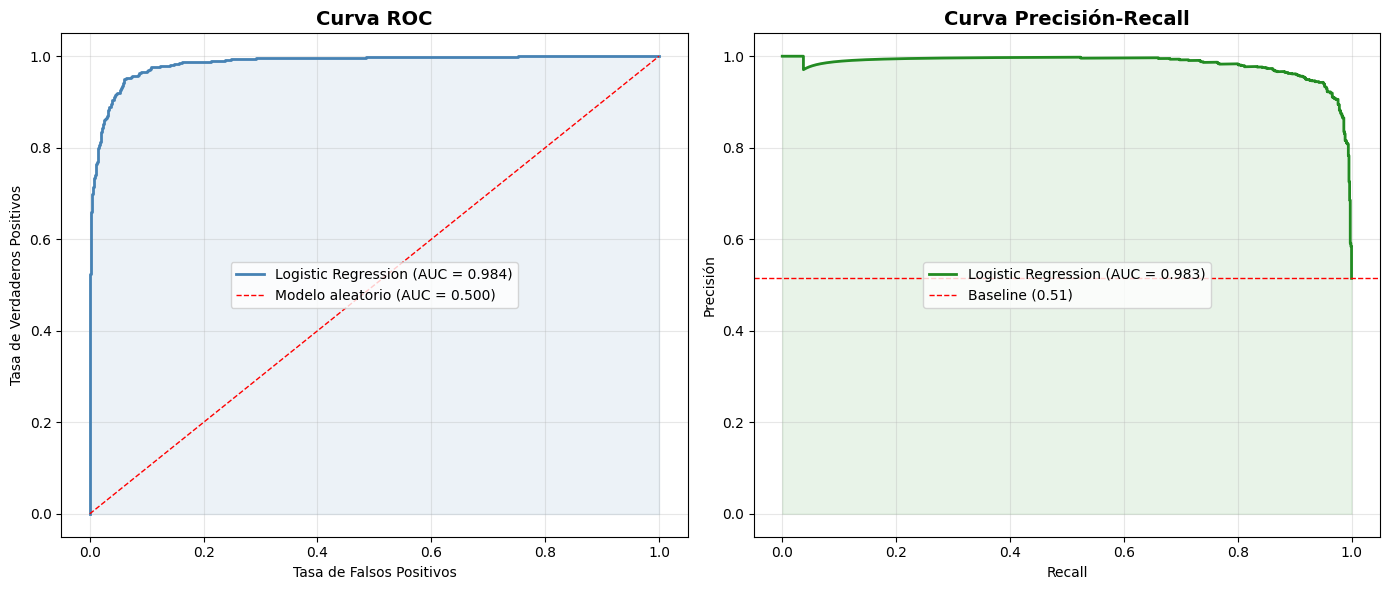

In [5]:
print("Curvas de evaluación")
print("=" * 60)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ── Gráfico 1: Curva ROC ──
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

axes[0].plot(fpr, tpr, color='steelblue', linewidth=2,
             label=f'Logistic Regression (AUC = {roc_auc:.3f})')
axes[0].plot([0, 1], [0, 1], color='red', linestyle='--',
             linewidth=1, label='Modelo aleatorio (AUC = 0.500)')
axes[0].fill_between(fpr, tpr, alpha=0.1, color='steelblue')
axes[0].set_title('Curva ROC', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Tasa de Falsos Positivos')
axes[0].set_ylabel('Tasa de Verdaderos Positivos')
axes[0].legend()
axes[0].grid(alpha=0.3)

# ── Gráfico 2: Curva Precisión-Recall ──
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

axes[1].plot(recall, precision, color='forestgreen', linewidth=2,
             label=f'Logistic Regression (AUC = {pr_auc:.3f})')
axes[1].axhline(y=y_test.mean(), color='red', linestyle='--',
                linewidth=1, label=f'Baseline ({y_test.mean():.2f})')
axes[1].fill_between(recall, precision, alpha=0.1, color='forestgreen')
axes[1].set_title('Curva Precisión-Recall', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precisión')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


Análisis de errores

Total de errores: 100

Tipo de errores:
- Falsos Positivos (predijo A, ganó B): 49
- Falsos Negativos (predijo B, ganó A): 51

Probabilidades en los erroes:
- Probabilidad promedio cuando falla: 52.3%
- Probabilidad promedio cuando acierta: 51.3%

Top 10 predicciones más confiadas pero incorrectas:
(El modelo estaba muy seguro pero se equivocó)


,Match Name,teamA_name,teamB_name,probability_teamA,teamA_won
4353,LEVIATÁN vs OESTE FWT,LEVIATÁN,OESTE FWT,1.000000,0
6570,SLICK vs Jaguares Esports,Jaguares Esports,SLICK,0.000056,1
4556,Louvre vs Orgless,Louvre,Orgless,0.000103,1
5765,PEEK Gaming vs Six Karma,PEEK Gaming,Six Karma,0.007882,1
4360,LEVIATÁN vs Team Samurai,LEVIATÁN,Team Samurai,0.984778,0
5630,Optix vs Meta Gaming,Meta Gaming,Optix,0.024024,1
477,Alter Ego vs CERBERUS Esports,Alter Ego,CERBERUS Esports,0.946878,0
1298,CBT Gaming vs Griffin E-Sports,CBT Gaming,Griffin E-Sports,0.936329,0
2652,FaZe Clan vs Ghost Gaming,FaZe Clan,Ghost Gaming,0.930900,0
6891,SoaR vs Bait Academy,Bait Academy,SoaR,0.071475,1


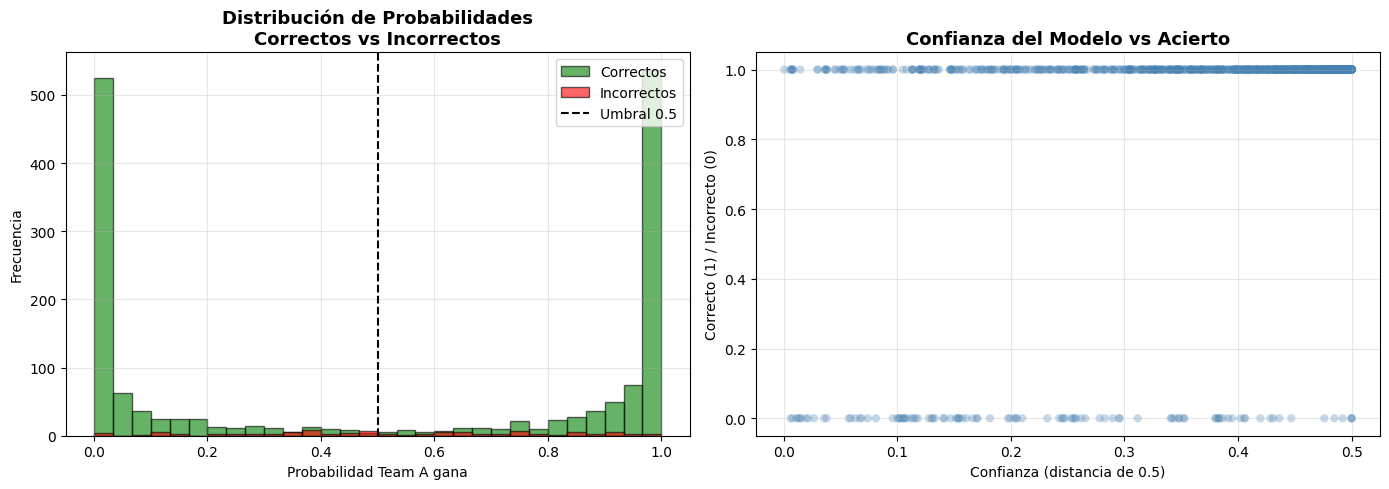

In [6]:
print("Análisis de errores")
print("=" * 60)

# Filtrar solo los errores
df_errors = df_results[df_results['correct'] == 0].copy()

print(f"\nTotal de errores: {len(df_errors):,}")

# ── Tipo de error ──
print("\nTipo de errores:")

# Falsos Positivos: predijo Team A gana pero ganó Team B
false_positives = df_errors[(df_errors['predicted'] == 1) & 
                             (df_errors['teamA_won'] == 0)]

# Falsos Negativos: predijo Team B gana pero ganó Team A
false_negatives = df_errors[(df_errors['predicted'] == 0) & 
                             (df_errors['teamA_won'] == 1)]

print(f"- Falsos Positivos (predijo A, ganó B): {len(false_positives):,}")
print(f"- Falsos Negativos (predijo B, ganó A): {len(false_negatives):,}")

# ── Probabilidades en los errores ──
print("\nProbabilidades en los erroes:")
print(f"- Probabilidad promedio cuando falla: {df_errors['probability_teamA'].mean()*100:.1f}%")
print(f"- Probabilidad promedio cuando acierta: {df_results[df_results['correct']==1]['probability_teamA'].mean()*100:.1f}%")

# ── Partidos más "sorpresivos" (más confiado pero equivocado) ──
print("\nTop 10 predicciones más confiadas pero incorrectas:")
print("(El modelo estaba muy seguro pero se equivocó)")

# Errores donde predijo Team A con alta probabilidad
worst_errors = df_errors.copy()
worst_errors['confidence'] = abs(worst_errors['probability_teamA'] - 0.5)
worst_errors = worst_errors.sort_values('confidence', ascending=False)

display(worst_errors[['Match Name', 'teamA_name', 'teamB_name',
                       'probability_teamA', 'teamA_won']].head(10))

# ── Visualización de probabilidades ──
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribución de probabilidades: correctos vs incorrectos
axes[0].hist(df_results[df_results['correct']==1]['probability_teamA'],
             bins=30, alpha=0.6, color='green', label='Correctos', edgecolor='black')
axes[0].hist(df_results[df_results['correct']==0]['probability_teamA'],
             bins=30, alpha=0.6, color='red', label='Incorrectos', edgecolor='black')
axes[0].axvline(x=0.5, color='black', linestyle='--', label='Umbral 0.5')
axes[0].set_title('Distribución de Probabilidades\nCorrectos vs Incorrectos',
                   fontsize=13, fontweight='bold')
axes[0].set_xlabel('Probabilidad Team A gana')
axes[0].set_ylabel('Frecuencia')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Confianza del modelo
confidence = abs(df_results['probability_teamA'] - 0.5)
axes[1].scatter(confidence, df_results['correct'],
                alpha=0.3, color='steelblue', edgecolor='none')
axes[1].set_title('Confianza del Modelo vs Acierto',
                   fontsize=13, fontweight='bold')
axes[1].set_xlabel('Confianza (distancia de 0.5)')
axes[1].set_ylabel('Correcto (1) / Incorrecto (0)')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

Análisis por año

Acurracy por año:


,year,total,correctas,accuracy
0,2021,992,937,94.455645
1,2022,660,620,93.939394
2,2023,24,21,87.500000
3,2024,14,14,100.000000
4,2025,34,32,94.117647


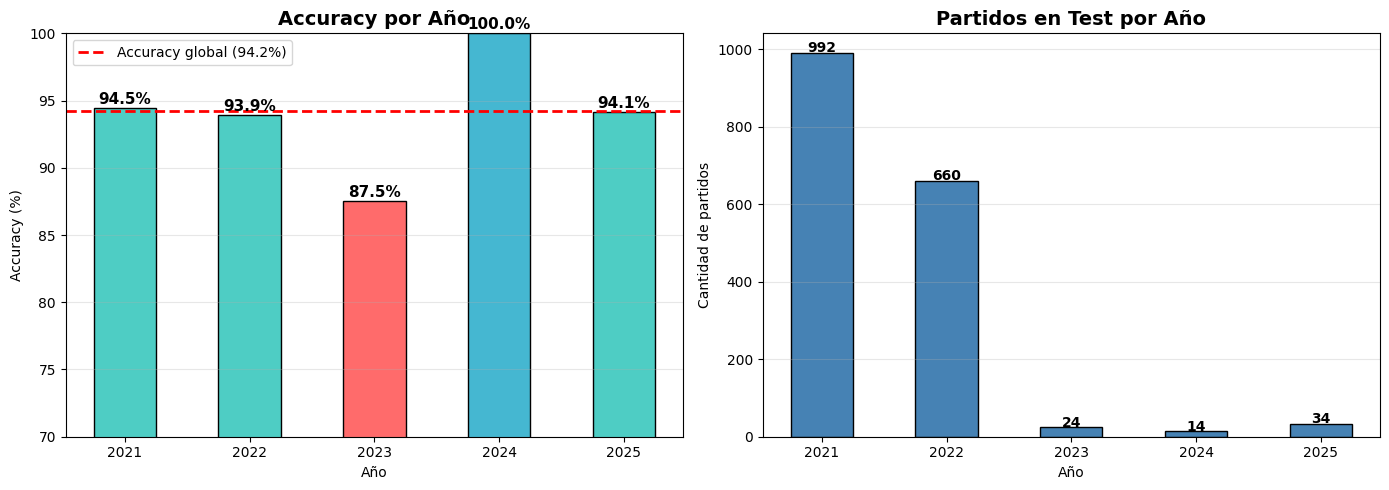

In [7]:
print("Análisis por año")
print("=" * 60)

# Calcular accuracy por año
accuracy_by_year = df_results.groupby('year').agg(
    total=('correct', 'count'),
    correctas=('correct', 'sum')
).reset_index()

accuracy_by_year['accuracy'] = accuracy_by_year['correctas'] / accuracy_by_year['total'] * 100

print("\nAcurracy por año:")
display(accuracy_by_year)

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Accuracy por año
colors = ['#FF6B6B' if acc < 90 else '#4ECDC4' if acc < 95 else '#45B7D1' 
          for acc in accuracy_by_year['accuracy']]

bars = axes[0].bar(accuracy_by_year['year'].astype(str),
                   accuracy_by_year['accuracy'],
                   color=colors, edgecolor='black', width=0.5)

axes[0].axhline(y=94.2, color='red', linestyle='--',
                linewidth=2, label='Accuracy global (94.2%)')
axes[0].set_title('Accuracy por Año', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Año')
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_ylim([70, 100])
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

for bar, acc in zip(bars, accuracy_by_year['accuracy']):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                f'{acc:.1f}%', ha='center', fontweight='bold', fontsize=11)

# Gráfico 2: Cantidad de partidos por año en test
axes[1].bar(accuracy_by_year['year'].astype(str),
            accuracy_by_year['total'],
            color='steelblue', edgecolor='black', width=0.5)
axes[1].set_title('Partidos en Test por Año', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Año')
axes[1].set_ylabel('Cantidad de partidos')
axes[1].grid(axis='y', alpha=0.3)

for i, (total, year) in enumerate(zip(accuracy_by_year['total'], accuracy_by_year['year'])):
    axes[1].text(i, total + 2, str(total), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

Equipos más dificiles de predecir

Equipos analizados (con ≥5 partidos): 153


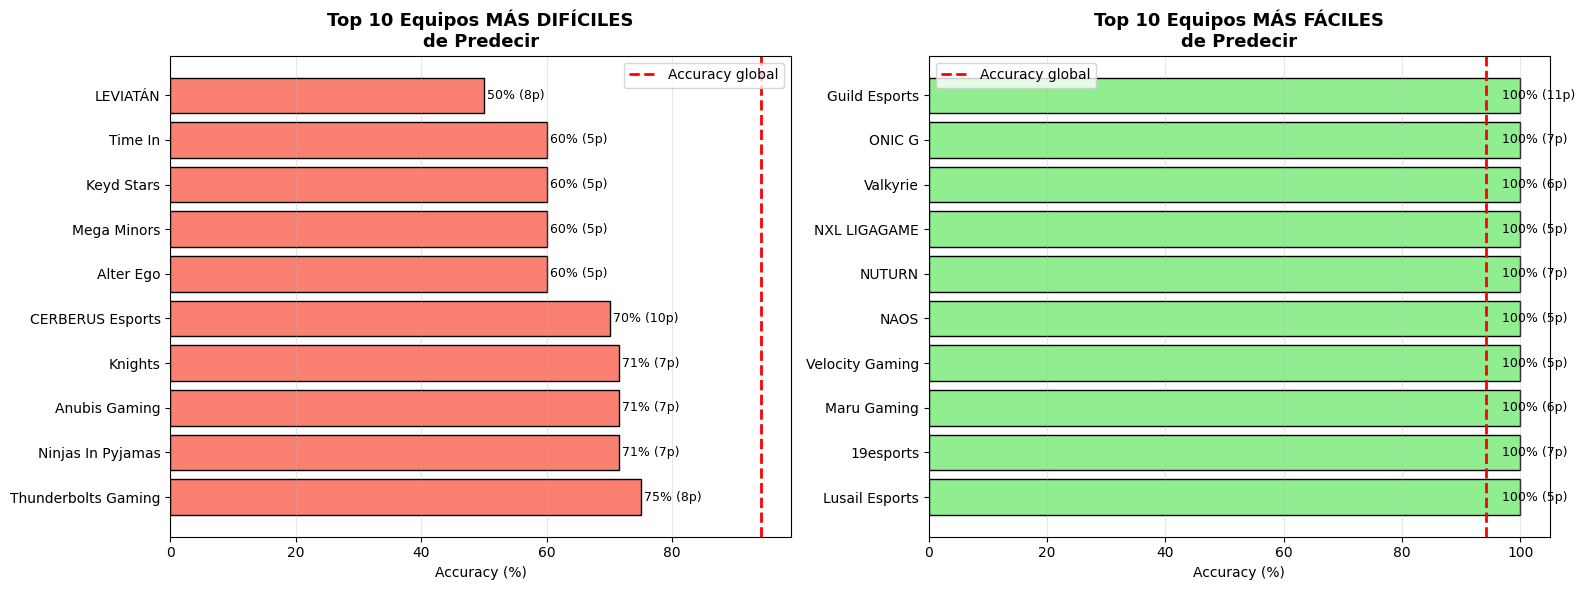


Top 10 quipos más dificiles:


,team,partidos,accuracy
0,LEVIATÁN,8,50.000000
1,Time In,5,60.000000
2,Keyd Stars,5,60.000000
3,Mega Minors,5,60.000000
4,Alter Ego,5,60.000000
5,CERBERUS Esports,10,70.000000
6,Knights,7,71.428571
7,Anubis Gaming,7,71.428571
8,Ninjas In Pyjamas,7,71.428571
9,Thunderbolts Gaming,8,75.000000


In [8]:
print("Equipos más dificiles de predecir")
print("=" * 60)

# Calcular accuracy por equipo
# Unir errores con nombres de equipos (tanto teamA como teamB)

# Resultados para teamA
team_results_A = df_results[['teamA_name', 'correct']].rename(
    columns={'teamA_name': 'team'}
)

# Resultados para teamB
team_results_B = df_results[['teamB_name', 'correct']].rename(
    columns={'teamB_name': 'team'}
)

# Combinar
team_results = pd.concat([team_results_A, team_results_B], ignore_index=True)

# Calcular accuracy por equipo
team_accuracy = team_results.groupby('team').agg(
    partidos=('correct', 'count'),
    aciertos=('correct', 'sum')
).reset_index()

team_accuracy['accuracy'] = team_accuracy['aciertos'] / team_accuracy['partidos'] * 100

# Filtrar equipos con al menos 5 partidos
team_accuracy = team_accuracy[team_accuracy['partidos'] >= 5]

# Top equipos más difíciles (menor accuracy)
harder_teams = team_accuracy.sort_values('accuracy', ascending=True).head(10)

# Top equipos más fáciles (mayor accuracy)
easier_teams = team_accuracy.sort_values('accuracy', ascending=False).head(10)

print(f"\nEquipos analizados (con ≥5 partidos): {len(team_accuracy)}")

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Más difíciles
axes[0].barh(harder_teams['team'], harder_teams['accuracy'],
             color='salmon', edgecolor='black')
axes[0].axvline(x=94.2, color='red', linestyle='--',
                linewidth=2, label='Accuracy global')
axes[0].set_title('Top 10 Equipos MÁS DIFÍCILES\nde Predecir',
                   fontsize=13, fontweight='bold')
axes[0].set_xlabel('Accuracy (%)')
axes[0].legend()
axes[0].grid(axis='x', alpha=0.3)
axes[0].invert_yaxis()

for i, (acc, partidos) in enumerate(zip(harder_teams['accuracy'],
                                         harder_teams['partidos'])):
    axes[0].text(acc + 0.5, i, f'{acc:.0f}% ({partidos}p)',
                va='center', fontsize=9)

# Gráfico 2: Más fáciles
axes[1].barh(easier_teams['team'], easier_teams['accuracy'],
             color='lightgreen', edgecolor='black')
axes[1].axvline(x=94.2, color='red', linestyle='--',
                linewidth=2, label='Accuracy global')
axes[1].set_title('Top 10 Equipos MÁS FÁCILES\nde Predecir',
                   fontsize=13, fontweight='bold')
axes[1].set_xlabel('Accuracy (%)')
axes[1].legend()
axes[1].grid(axis='x', alpha=0.3)
axes[1].invert_yaxis()

for i, (acc, partidos) in enumerate(zip(easier_teams['accuracy'],
                                         easier_teams['partidos'])):
    axes[1].text(acc - 3, i, f'{acc:.0f}% ({partidos}p)',
                va='center', fontsize=9, color='black')

plt.tight_layout()
plt.show()

# Tabla resumen
print("\nTop 10 quipos más dificiles:")
display(harder_teams[['team', 'partidos', 'accuracy']].reset_index(drop=True))

In [9]:
import os

print("Exportando datos a power bi")
print("=" * 60)

# Crear carpeta para Power BI
os.makedirs('../reports/powerbi/', exist_ok=True)

# ── ARCHIVO 1: Predicciones completas ──
print("\nExportando predicciones...")

df_powerbi = df_results[[
    'Match Name', 'teamA_name', 'teamB_name', 'year',
    'teamA_won', 'predicted', 'probability_teamA', 'correct',
    'teamA_kills', 'teamB_kills',
    'teamA_acs', 'teamB_acs',
    'teamA_rating', 'teamB_rating',
    'teamA_kd', 'teamB_kd',
    'diff_kills', 'diff_acs', 'diff_kd'
]].copy()

# Agregar columnas descriptivas
df_powerbi['resultado_real'] = df_powerbi['teamA_won'].map(
    {1: 'Team A ganó', 0: 'Team B ganó'}
)
df_powerbi['resultado_predicho'] = df_powerbi['predicted'].map(
    {1: 'Team A ganó', 0: 'Team B ganó'}
)
df_powerbi['prediccion_correcta'] = df_powerbi['correct'].map(
    {1: 'Correcta', 0: 'Incorrecta'}
)
df_powerbi['confianza'] = abs(df_powerbi['probability_teamA'] - 0.5) * 2

df_powerbi.to_csv('../reports/powerbi/predicciones.csv', index=False)
print(f"predicciones.csv → {len(df_powerbi):,} filas")

# ── ARCHIVO 2: Accuracy por año ──
print("\nExportando accuracy por año...")

accuracy_year = df_results.groupby('year').agg(
    total_partidos=('correct', 'count'),
    partidos_correctos=('correct', 'sum')
).reset_index()
accuracy_year['accuracy'] = (accuracy_year['partidos_correctos'] / 
                              accuracy_year['total_partidos'] * 100).round(2)

accuracy_year.to_csv('../reports/powerbi/accuracy_por_año.csv', index=False)
print(f"accuracy_por_año.csv → {len(accuracy_year):,} filas")

# ── ARCHIVO 3: Stats por equipo ──
print("\nExportando stats por equipo...")

# Equipos como Team A
stats_A = df_results.groupby('teamA_name').agg(
    partidos=('correct', 'count'),
    victorias=('teamA_won', 'sum'),
    predicciones_correctas=('correct', 'sum'),
    avg_acs=('teamA_acs', 'mean'),
    avg_kd=('teamA_kd', 'mean'),
    avg_kills=('teamA_kills', 'mean')
).reset_index().rename(columns={'teamA_name': 'equipo'})

# Equipos como Team B
stats_B = df_results.groupby('teamB_name').agg(
    partidos=('correct', 'count'),
    victorias_b=('teamA_won', lambda x: (x==0).sum()),
    predicciones_correctas=('correct', 'sum'),
    avg_acs=('teamB_acs', 'mean'),
    avg_kd=('teamB_kd', 'mean'),
    avg_kills=('teamB_kills', 'mean')
).reset_index().rename(columns={'teamB_name': 'equipo'})

# Combinar
team_stats_powerbi = pd.merge(stats_A, stats_B, on='equipo', how='outer',
                               suffixes=('_A', '_B'))

# Calcular métricas finales
team_stats_powerbi['total_partidos'] = (
    team_stats_powerbi['partidos_A'].fillna(0) + 
    team_stats_powerbi['partidos_B'].fillna(0)
)
team_stats_powerbi['total_victorias'] = (
    team_stats_powerbi['victorias'].fillna(0) + 
    team_stats_powerbi['victorias_b'].fillna(0)
)
team_stats_powerbi['winrate'] = (
    team_stats_powerbi['total_victorias'] / 
    team_stats_powerbi['total_partidos'] * 100
).round(2)
team_stats_powerbi['accuracy_modelo'] = (
    (team_stats_powerbi['predicciones_correctas_A'].fillna(0) + 
     team_stats_powerbi['predicciones_correctas_B'].fillna(0)) /
    team_stats_powerbi['total_partidos'] * 100
).round(2)

# Guardar columnas relevantes
team_stats_final = team_stats_powerbi[[
    'equipo', 'total_partidos', 'total_victorias', 
    'winrate', 'accuracy_modelo',
    'avg_acs_A', 'avg_kd_A', 'avg_kills_A'
]].rename(columns={
    'avg_acs_A': 'avg_acs',
    'avg_kd_A': 'avg_kd', 
    'avg_kills_A': 'avg_kills'
})

# Filtrar equipos con al menos 3 partidos
team_stats_final = team_stats_final[team_stats_final['total_partidos'] >= 3]

team_stats_final.to_csv('../reports/powerbi/stats_equipos.csv', index=False)
print(f"stats_equipos.csv → {len(team_stats_final):,} equipos")

# ── ARCHIVO 4: Resumen del modelo ──
print("\nExportando resumen del modelo...")

model_summary = pd.DataFrame({
    'metrica': ['Accuracy', 'ROC-AUC', 'Total Partidos', 
                'Partidos Train', 'Partidos Test',
                'Predicciones Correctas', 'Predicciones Incorrectas'],
    'valor': [94.2, 0.984, 8617, 6893, 1724, 1624, 100]
})

model_summary.to_csv('../reports/powerbi/resumen_modelo.csv', index=False)
print(f"resumen_modelo.csv → {len(model_summary):,} métricas")

print("\n" + "=" * 60)
print("TODOS LOS ARCHIVOS EXPORTADOS")
print("=" * 60)

Exportando datos a power bi

Exportando predicciones...
predicciones.csv → 1,724 filas

Exportando accuracy por año...
accuracy_por_año.csv → 5 filas

Exportando stats por equipo...
stats_equipos.csv → 365 equipos

Exportando resumen del modelo...
resumen_modelo.csv → 7 métricas

TODOS LOS ARCHIVOS EXPORTADOS


In [11]:
print("Re-exportando accuracy_por_año...")

# Cargar directamente el archivo existente
df_accuracy = pd.read_csv('../reports/powerbi/accuracy_por_año.csv')

# Exportar con COMA como separador decimal
df_accuracy.to_csv(
    '../reports/powerbi/accuracy_por_año.csv',
    index=False,
    decimal=','    # ← Coma como decimal para Power BI en español
)

print("Archivo re-exportado con coma decimal")
print("\nVista previa del archivo:")

# Leer como texto para verificar que tiene comas
with open('../reports/powerbi/accuracy_por_año.csv', 'r') as f:
    print(f.read())

Re-exportando accuracy_por_año...
Archivo re-exportado con coma decimal

Vista previa del archivo:
year,total_partidos,partidos_correctos,accuracy
2021,992,937,"94,46"
2022,660,620,"93,94"
2023,24,21,"87,5"
2024,14,14,"100,0"
2025,34,32,"94,12"

